<a href="https://colab.research.google.com/github/sandeeepmedepalli/ml-colony-classification/blob/main/enhanced_code_of_ML_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, random, math
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split


Mounted at /content/drive


In [ ]:
# ====== PATHS (separate pretrain vs ground truth) ======
BASE_DIR = "/content/drive/MyDrive/22022540"

# Public dataset (10-class pretrain)
CSV_PATH   = os.path.join(BASE_DIR, "annot_tab.csv")
IMAGES_DIR_PUBLIC = BASE_DIR  # images are directly here


# Ground-truth from CVAT (zip) — keep separate
GT_ZIP_PATH = os.path.join(BASE_DIR, "ground_truth","ground_truth_one", "ground_truth_dataset.zip")
# Ground-truth images (the exact images used in CVAT)
IMAGES_DIR_GT = "/content/drive/MyDrive/22022540/ground_truth/ground_truth_one"

# Output workspaces (separate)
WORKDIR_PRETRAIN = "/content/colony_stage2_pretrain10"
WORKDIR_GT       = "/content/colony_stage2_groundtruth"
os.makedirs(WORKDIR_PRETRAIN, exist_ok=True)
os.makedirs(WORKDIR_GT, exist_ok=True)

# Patch settings
PATCH_SIZE = 100
PAD_TO_SQUARE = True

# How much extra context around the colony bbox
BOX_EXPAND = 0.20


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
print("CSV_PATH:  ", CSV_PATH)
print("GT_ZIP_PATH:", GT_ZIP_PATH)


Device: cuda
CSV_PATH:   /content/drive/MyDrive/22022540/annot_tab.csv
GT_ZIP_PATH: /content/drive/MyDrive/22022540/ground_truth/ground_truth_one/ground_truth_dataset.zip


In [ ]:
#Copy images from Drive → local Colab
import shutil, os

LOCAL_IMG_DIR = "/content/colony_images"
os.makedirs(LOCAL_IMG_DIR, exist_ok=True)

for f in os.listdir(IMAGES_DIR_PUBLIC):
    src = os.path.join(IMAGES_DIR_PUBLIC, f)
    dst = os.path.join(LOCAL_IMG_DIR, f)
    if os.path.isfile(src) and not os.path.exists(dst):
        shutil.copy2(src, dst)

IMAGES_DIR_PUBLIC = LOCAL_IMG_DIR
print("Now using local images:", IMAGES_DIR_PUBLIC)

Now using local images: /content/colony_images


In [ ]:
required_cols = [
    "label_name","bbox_x","bbox_y","bbox_width","bbox_height",
    "image_name","image_width","image_height"
]

df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"CSV missing columns: {missing}\nFound: {list(df.columns)}")

# Make numeric columns numeric
for c in ["bbox_x","bbox_y","bbox_width","bbox_height","image_width","image_height"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop bad rows
df = df.dropna(subset=required_cols).copy()
df = df[(df["bbox_width"] > 0) & (df["bbox_height"] > 0)].copy()

print("Rows (boxes):", len(df))
print("Unique classes:", df["label_name"].nunique())
print(df["label_name"].value_counts().head(24))


Rows (boxes): 56862
Unique classes: 24
label_name
sp21    11160
sp23     7067
sp22     6814
sp06     5513
sp10     4364
sp05     4102
sp19     2782
sp13     1799
sp09     1775
sp02     1530
sp18     1383
sp16     1348
sp14     1102
sp07     1087
sp15      866
sp20      853
sp24      787
sp11      481
sp12      461
sp01      397
sp08      368
sp04      304
sp03      295
sp17      224
Name: count, dtype: int64


In [ ]:
# 10-class list
CLASSES_10 = ["sp02","sp05","sp06","sp07","sp10","sp14","sp16","sp19","sp21","sp23"]

# Count check
counts = df["label_name"].value_counts()
def show_counts(class_list, name):
    print(f"\n{name} counts:")
    for c in class_list:
        print(f"  {c}: {int(counts.get(c, 0))}")

show_counts(CLASSES_10, "10-class")

# Safety checks for classes count to be greater than 1000 , as we are working on thousand
for c in CLASSES_10:
    if counts.get(c, 0) < 1000:
        raise ValueError(f"{c} has < 1000 boxes. Pick another class.")


10-class counts:
  sp02: 1530
  sp05: 4102
  sp06: 5513
  sp07: 1087
  sp10: 4364
  sp14: 1102
  sp16: 1348
  sp19: 2782
  sp21: 11160
  sp23: 7067


In [ ]:
def sample_rows_for_class(df, cls, n, seed, exclude_index_set=None):
    """Sample n rows for one class. Optionally exclude some row indices."""
    sub = df[df["label_name"] == cls]
    if exclude_index_set is not None:
        sub = sub[~sub.index.isin(exclude_index_set)]
    if len(sub) < n:
        raise ValueError(f"Not enough rows for {cls}: need {n}, have {len(sub)} after exclusions.")
    return sub.sample(n=n, random_state=seed)

# 10-class pretrain sampling: 1000 per class
pretrain_parts = []
used_idx = set()

for i, cls in enumerate(CLASSES_10):
    samp = sample_rows_for_class(df, cls, n=1000, seed=SEED+i)
    pretrain_parts.append(samp)
    used_idx.update(samp.index.tolist())

df_pretrain = pd.concat(pretrain_parts).reset_index(drop=True)
print("Pretrain rows:", len(df_pretrain), " expected:", 10*1000)

Pretrain rows: 10000  expected: 10000


In [ ]:
# Cropping function where we convert bbox to patch (with optional context expansion)
def crop_patch(
    img: Image.Image,
    x, y, w, h,
    pad_to_square=True,
    expand_factor=0.20,    # e.g., 0.20 means 20% of bbox size added on each side
    expand_px=0           # optional fixed extra pixels on each side
):
    # Expand bbox to include context
    dx = expand_px + expand_factor * float(w)
    dy = expand_px + expand_factor * float(h)

    x1 = int(round(x - dx))
    y1 = int(round(y - dy))
    x2 = int(round(x + w + dx))
    y2 = int(round(y + h + dy))

    # Clip to image boundaries
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(img.width, x2); y2 = min(img.height, y2)

    # Safety: avoid empty crops
    if x2 <= x1: x2 = min(img.width, x1 + 1)
    if y2 <= y1: y2 = min(img.height, y1 + 1)

    patch = img.crop((x1, y1, x2, y2))

    if not pad_to_square:
        return patch

    # Pad to square (keeps aspect ratio before resize)
    side = max(patch.width, patch.height)
    new_img = Image.new("L", (side, side), color=0)  # grayscale canvas
    px = (side - patch.width) // 2
    py = (side - patch.height) // 2
    patch = patch.convert("L")
    new_img.paste(patch, (px, py))
    return new_img


In [ ]:
class ColonyPatchDatasetCached(Dataset):
    def __init__(self, df_rows, images_dir, class_to_idx, transform=None):
        self.df = df_rows.reset_index(drop=True)
        self.images_dir = images_dir
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.cache = {}  # idx to PIL RGB patch

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx not in self.cache:
            r = self.df.iloc[idx]
            img_path = os.path.join(self.images_dir, os.path.basename(r["image_name"]))
            img = Image.open(img_path).convert("L")  # image is converted to gray scale

            patch = crop_patch(   # crop patch and resize it to 100*100
                img, r["bbox_x"], r["bbox_y"], r["bbox_width"], r["bbox_height"],
                pad_to_square=PAD_TO_SQUARE,
                expand_factor=BOX_EXPAND
            ).resize((PATCH_SIZE, PATCH_SIZE), resample=Image.BILINEAR)

            patch_rgb = Image.merge("RGB", (patch, patch, patch))
            self.cache[idx] = patch_rgb

        patch_rgb = self.cache[idx]
        y = self.class_to_idx[str(self.df.iloc[idx]["label_name"])]

        if self.transform:
            patch_rgb = self.transform(patch_rgb)

        return patch_rgb, y


In [ ]:
# ImageNet normalization stats (because we use an ImageNet-pretrained backbone)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [ ]:
def accuracy(pred_logits, y):
    preds = pred_logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optim, criterion):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optim.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optim.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

@torch.no_grad()  # helps to stop gradient tracking during evaluation
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n


In [ ]:
class_to_idx_10 = {c:i for i,c in enumerate(CLASSES_10)}

train_df_10, test_df_10 = train_test_split(
    df_pretrain,
    test_size=0.2,
    random_state=SEED,
    stratify=df_pretrain["label_name"]
)

ds_train_10 = ColonyPatchDatasetCached(train_df_10, IMAGES_DIR_PUBLIC, class_to_idx_10, transform=train_tf)
ds_test_10  = ColonyPatchDatasetCached(test_df_10,  IMAGES_DIR_PUBLIC, class_to_idx_10, transform=test_tf)

train_loader_10 = DataLoader(ds_train_10, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
test_loader_10  = DataLoader(ds_test_10,  batch_size=128, shuffle=False, num_workers=0, pin_memory=True)


print("10-class train:", len(ds_train_10), "test:", len(ds_test_10))


10-class train: 8000 test: 2000


In [ ]:
#we are going to use the pretrained back bone for imagenet weights
#ResNet-18 architecture suitable for efficient transfer learning.
#Load the official pretrained ResNet18 weights trained on ImageNet-1K(1000 classes), version 1
weights = models.ResNet18_Weights.IMAGENET1K_V1
model_10 = models.resnet18(weights=weights)

# change the resnet classifier head from 1000 to 10 classes
in_features = model_10.fc.in_features
model_10.fc = nn.Linear(in_features, len(CLASSES_10))

model_10 = model_10.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [ ]:
EPOCHS_10 = 10  # start small; you can increase later

best_acc = 0.0
for epoch in range(1, EPOCHS_10+1):
    tr_loss, tr_acc = train_one_epoch(model_10, train_loader_10, optimizer, criterion)
    te_loss, te_acc = eval_one_epoch(model_10, test_loader_10, criterion)

    print(f"[10-class] Epoch {epoch:02d} | train acc {tr_acc:.3f} | test acc {te_acc:.3f}")

    #save the model with best accuracy
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model_10.state_dict(), os.path.join(WORKDIR_PRETRAIN, "resnet18_pretrained_10class.pt"))

print("Best 10-class test acc:", best_acc)


[10-class] Epoch 01 | train acc 0.665 | test acc 0.812
[10-class] Epoch 02 | train acc 0.863 | test acc 0.877
[10-class] Epoch 03 | train acc 0.900 | test acc 0.876
[10-class] Epoch 04 | train acc 0.914 | test acc 0.908
[10-class] Epoch 05 | train acc 0.926 | test acc 0.909
[10-class] Epoch 06 | train acc 0.936 | test acc 0.910
[10-class] Epoch 07 | train acc 0.942 | test acc 0.918
[10-class] Epoch 08 | train acc 0.944 | test acc 0.925
[10-class] Epoch 09 | train acc 0.953 | test acc 0.922
[10-class] Epoch 10 | train acc 0.954 | test acc 0.900
Best 10-class test acc: 0.925


In [ ]:
import os
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torchvision.models as models
import torch.nn as nn

@torch.no_grad()
def evaluate_model(model, loader, class_names, device, title=""):
    model.eval()
    y_true, y_pred = [], []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        y_true.append(y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    print("\n" + "="*80)
    print(title)
    print("="*80)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
    return cm


In [ ]:
# ===== Evaluate BEST 10-class PUBLIC model =====

PATH_10 = os.path.join(
    WORKDIR_PRETRAIN,   # <-- use the REAL variable from your notebook
    "resnet18_pretrained_10class.pt"
)

model_10_eval = models.resnet18(weights=None)
model_10_eval.fc = nn.Linear(model_10_eval.fc.in_features, len(CLASSES_10))
model_10_eval.load_state_dict(torch.load(PATH_10, map_location=DEVICE))
model_10_eval = model_10_eval.to(DEVICE)

cm_10 = evaluate_model(
    model_10_eval,
    test_loader_10,
    CLASSES_10,
    DEVICE,
    title="Evaluation: Best 10-Class PUBLIC ResNet18"
)



Evaluation: Best 10-Class PUBLIC ResNet18
Confusion Matrix:
[[195   1   0   0   0   0   1   0   2   1]
 [  2 193   0   1   0   1   0   0   2   1]
 [  0   0 178   1   2   8   0   4   2   5]
 [  0   0   4 191   2   0   0   1   0   2]
 [  0   0  11   1 177   1   1   2   0   7]
 [  0   0   4   0   0 186   0   9   1   0]
 [  0   0   2   1   2   2 181   8   2   2]
 [  2   0   1   0   0   2   0 195   0   0]
 [  0   0   1   3   0   2   0   0 193   1]
 [  3   0  21   3   6   2   4   0   0 161]]

Classification Report:
              precision    recall  f1-score   support

        sp02      0.965     0.975     0.970       200
        sp05      0.995     0.965     0.980       200
        sp06      0.802     0.890     0.844       200
        sp07      0.950     0.955     0.953       200
        sp10      0.937     0.885     0.910       200
        sp14      0.912     0.930     0.921       200
        sp16      0.968     0.905     0.935       200
        sp19      0.890     0.975     0.931       2

In [ ]:
import os, zipfile, yaml
import pandas as pd
from PIL import Image

# Extract CVAT export zip into runtime
GT_DIR = "/content/cvat_export_gt"
os.makedirs(GT_DIR, exist_ok=True)

with zipfile.ZipFile(GT_ZIP_PATH, "r") as z:
    z.extractall(GT_DIR)

# Read classes from YAML
yaml_path = os.path.join(GT_DIR, "data.yaml")
with open(yaml_path, "r") as f:
    y = yaml.safe_load(f)

names = y["names"]
if isinstance(names, dict):
    id_to_class = {int(k): v for k, v in names.items()}
else:
    id_to_class = {i: v for i, v in enumerate(names)}

CLASSES_FT = [id_to_class[i] for i in sorted(id_to_class.keys())]
print("GT classes from yaml:", CLASSES_FT)

# Find labels folder
LABELS_DIR = os.path.join(GT_DIR, "labels", "train")
if not os.path.isdir(LABELS_DIR):
    LABELS_DIR = os.path.join(GT_DIR, "labels")
if not os.path.isdir(LABELS_DIR):
    raise FileNotFoundError("Could not find labels folder inside CVAT export zip.")

def find_image_path(images_dir, stem):
    for ext in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"]:
        p = os.path.join(images_dir, stem + ext)
        if os.path.exists(p):
            return p
    return None

rows = []
missing = []

for txt_name in os.listdir(LABELS_DIR):
    if not txt_name.endswith(".txt"):
        continue

    stem = os.path.splitext(txt_name)[0]  # sp01_img01
    img_path = find_image_path(IMAGES_DIR_GT, stem)
    if img_path is None:
        missing.append(stem)
        continue

    img = Image.open(img_path)
    W, H = img.size

    txt_path = os.path.join(LABELS_DIR, txt_name)
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls_id = int(float(parts[0]))
            cx, cy, w, h = map(float, parts[1:])

            bw = w * W
            bh = h * H
            x1 = (cx * W) - bw / 2
            y1 = (cy * H) - bh / 2

            rows.append({
                "label_name": id_to_class[cls_id],
                "bbox_x": x1,
                "bbox_y": y1,
                "bbox_width": bw,
                "bbox_height": bh,
                "image_name": os.path.basename(img_path),
                "image_width": W,
                "image_height": H,
            })

df_gt = pd.DataFrame(rows)
print("GT boxes:", len(df_gt))
print(df_gt["label_name"].value_counts())

if missing:
    print("WARNING: Missing images for label files (examples):", missing[:10])


GT classes from yaml: ['sp01', 'sp02', 'sp03', 'sp04']
GT boxes: 254
label_name
sp02    82
sp04    64
sp01    55
sp03    53
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

counts = df_gt["label_name"].value_counts()
min_count = counts.min()

try:
    train_df_gt, test_df_gt = train_test_split(
        df_gt, test_size=0.2, random_state=SEED,
        stratify=df_gt["label_name"]
    )
    print("Using stratified 80/20 split")
except ValueError as e:
    print("Stratified split failed (some class too small). Falling back to random 80/20.")
    train_df_gt, test_df_gt = train_test_split(
        df_gt, test_size=0.2, random_state=SEED, shuffle=True
    )

print("Train:", len(train_df_gt), "Test:", len(test_df_gt))


Using stratified 80/20 split
Train: 203 Test: 51


In [ ]:
from torch.utils.data import DataLoader

class_to_idx_gt = {c:i for i,c in enumerate(CLASSES_FT)}

ds_train_gt = ColonyPatchDatasetCached(train_df_gt, IMAGES_DIR_GT, class_to_idx_gt, transform=train_tf)
ds_test_gt  = ColonyPatchDatasetCached(test_df_gt,  IMAGES_DIR_GT, class_to_idx_gt, transform=test_tf)

train_loader_gt = DataLoader(ds_train_gt, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader_gt  = DataLoader(ds_test_gt,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

ckpt_10 = os.path.join(WORKDIR_PRETRAIN, "resnet18_pretrained_10class.pt")

model = models.resnet18(weights=None)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)  # temp head to load checkpoint
model.load_state_dict(torch.load(ckpt_10, map_location="cpu"))

# replace head to match GT classes
model.fc = nn.Linear(in_features, len(CLASSES_FT))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()


In [ ]:
# Directory where fine-tuned models are saved
WORKDIR_FINETUNE = "/content/work_finetune"
os.makedirs(WORKDIR_FINETUNE, exist_ok=True)

BEST_PATH_FT = os.path.join(WORKDIR_FINETUNE, "best_finetuned_on_newtest.pt")

best_acc = 0.0


In [ ]:
print("\n===== PHASE 1: Head-only training =====")

for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS_HEAD = 10
for epoch in range(1, EPOCHS_HEAD + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader_gt, optimizer, criterion)
    te_loss, te_acc = eval_one_epoch(model, test_loader_gt, criterion)

    print(f"[HEAD] Epoch {epoch:02d} | train acc {tr_acc:.3f} | test acc {te_acc:.3f}")

    # ✅ SAVE BEST MODEL
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), BEST_PATH_FT)
        print("  ✅ Saved NEW BEST model (Phase 1)")



===== PHASE 1: Head-only training =====
[HEAD] Epoch 01 | train acc 0.320 | test acc 0.667
  ✅ Saved NEW BEST model (Phase 1)
[HEAD] Epoch 02 | train acc 0.665 | test acc 0.824
  ✅ Saved NEW BEST model (Phase 1)
[HEAD] Epoch 03 | train acc 0.734 | test acc 0.843
  ✅ Saved NEW BEST model (Phase 1)
[HEAD] Epoch 04 | train acc 0.847 | test acc 0.863
  ✅ Saved NEW BEST model (Phase 1)
[HEAD] Epoch 05 | train acc 0.862 | test acc 0.843
[HEAD] Epoch 06 | train acc 0.911 | test acc 0.863
[HEAD] Epoch 07 | train acc 0.906 | test acc 0.863
[HEAD] Epoch 08 | train acc 0.901 | test acc 0.882
  ✅ Saved NEW BEST model (Phase 1)
[HEAD] Epoch 09 | train acc 0.916 | test acc 0.863
[HEAD] Epoch 10 | train acc 0.931 | test acc 0.863


In [ ]:
print("\n===== PHASE 2: Full fine-tuning =====")

for p in model.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS_FULL = 10
for epoch in range(1, EPOCHS_FULL + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader_gt, optimizer, criterion)
    te_loss, te_acc = eval_one_epoch(model, test_loader_gt, criterion)

    print(f"[FULL] Epoch {epoch:02d} | train acc {tr_acc:.3f} | test acc {te_acc:.3f}")

    # ✅ SAVE BEST MODEL (OVERALL)
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), BEST_PATH_FT)
        print("  ✅ Saved NEW BEST model (Phase 2)")



===== PHASE 2: Full fine-tuning =====
[FULL] Epoch 01 | train acc 0.931 | test acc 0.804
[FULL] Epoch 02 | train acc 0.980 | test acc 0.863
[FULL] Epoch 03 | train acc 0.980 | test acc 0.882
[FULL] Epoch 04 | train acc 0.985 | test acc 0.941
  ✅ Saved NEW BEST model (Phase 2)
[FULL] Epoch 05 | train acc 0.990 | test acc 0.902
[FULL] Epoch 06 | train acc 0.970 | test acc 0.941
[FULL] Epoch 07 | train acc 0.980 | test acc 0.941
[FULL] Epoch 08 | train acc 0.985 | test acc 0.941
[FULL] Epoch 09 | train acc 0.975 | test acc 0.922
[FULL] Epoch 10 | train acc 1.000 | test acc 0.882


In [ ]:
# =============================================================================
# 2) BEST 4-class IN-HOUSE model (ResNet18 fine-tuned)
# =============================================================================
# IMPORTANT:
# - CLASSES_FT should come from your in-house CVAT YAML (the real class list)
# - test_loader_new should be your in-house test DataLoader
#
# Update this path to match YOUR saved best in-house fine-tune checkpoint:
PATH_INHOUSE = os.path.join(WORKDIR_FINETUNE, "best_finetuned_on_newtest.pt")

model_inhouse_eval = models.resnet18(weights=None)
model_inhouse_eval.fc = nn.Linear(model_inhouse_eval.fc.in_features, len(CLASSES_FT))
model_inhouse_eval.load_state_dict(torch.load(PATH_INHOUSE, map_location=DEVICE))
model_inhouse_eval = model_inhouse_eval.to(DEVICE)

cm_inhouse = evaluate_model(
    model_inhouse_eval,
    test_loader_gt,
    CLASSES_FT,
    DEVICE,
    title="Evaluation: Best 4-Class IN-HOUSE ResNet18 (Fine-Tuned)"
)


Evaluation: Best 4-Class IN-HOUSE ResNet18 (Fine-Tuned)
Confusion Matrix:
[[11  0  0  0]
 [ 0 15  1  0]
 [ 0  0  9  2]
 [ 0  0  0 13]]

Classification Report:
              precision    recall  f1-score   support

        sp01      1.000     1.000     1.000        11
        sp02      1.000     0.938     0.968        16
        sp03      0.900     0.818     0.857        11
        sp04      0.867     1.000     0.929        13

    accuracy                          0.941        51
   macro avg      0.942     0.939     0.938        51
weighted avg      0.944     0.941     0.941        51



In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torchvision.models as models

# ============================================================
# 0) PUBLIC checkpoint (10-class)  (same as your code)
# ============================================================
assert "WORKDIR_PRETRAIN" in globals(), "WORKDIR_PRETRAIN not found in notebook."
PUBLIC_CKPT_PATH = os.path.join(WORKDIR_PRETRAIN, "resnet18_pretrained_10class.pt")
assert os.path.exists(PUBLIC_CKPT_PATH), f"Missing PUBLIC checkpoint: {PUBLIC_CKPT_PATH}"

# ============================================================
# 1) IN-HOUSE checkpoint (auto-find best_finetuned_on_newtest.pt)
# ============================================================
candidate_dirs = []
if "WORKDIR_FINETUNE" in globals(): candidate_dirs.append(WORKDIR_FINETUNE)
if "WORKDIR" in globals(): candidate_dirs.append(WORKDIR)
candidate_dirs += ["/content", "/content/work_finetune", "/content/work_finetune/"]

cands = []
for d in candidate_dirs:
    if isinstance(d, str) and os.path.exists(d):
        cands += glob.glob(os.path.join(d, "**", "best_finetuned_on_newtest.pt"), recursive=True)

if not cands:
    cands = glob.glob("/content/**/best_finetuned_on_newtest.pt", recursive=True)

assert len(cands) > 0, (
    "Could not find best_finetuned_on_newtest.pt anywhere under /content.\n"
    "Make sure your fine-tuning cell ran and saved the best model."
)

INHOUSE_CKPT_PATH = sorted(cands, key=len)[0]
print("✅ Found IN-HOUSE checkpoint:", INHOUSE_CKPT_PATH)

# ============================================================
# 2) Output folder
# ============================================================
OUT_DIR = os.path.join("/content", "reports_out")
os.makedirs(OUT_DIR, exist_ok=True)
print("✅ Outputs will be saved to:", OUT_DIR)

# ============================================================
# 3) Helpers: evaluate -> (cm, report_dict, report_str)
# ============================================================
@torch.no_grad()
def eval_to_cm_and_report(model, loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy()

        # y might be on CPU already; this makes it robust:
        y_true.append(y.detach().cpu().numpy())
        y_pred.append(pred)

    y_true = np.concatenate(y_true) if len(y_true) else np.array([], dtype=int)
    y_pred = np.concatenate(y_pred) if len(y_pred) else np.array([], dtype=int)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

    report_dict = classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=3,
        zero_division=0,
        output_dict=True
    )
    report_str = classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=3,
        zero_division=0
    )
    return cm, report_dict, report_str

def save_cm_png_blues_paper(
    cm,
    class_names,
    out_path,
    title="Confusion Matrix",
    normalize=False,
    show_colorbar=True   # ✅ added toggle
):
    """
    Paper-style confusion matrix:
    - Blue/white colormap (like PDF)
    - Big fonts
    - Thick gridlines
    - Square cells
    - WITH colorbar (optional)
    """
    cm = np.array(cm)

    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True) + 1e-9
        cm_show = cm / row_sums
        vmin, vmax = 0.0, 1.0
    else:
        cm_show = cm
        vmin, vmax = 0.0, float(cm_show.max()) if cm_show.size else 1.0

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor("white")

    # ✅ Blue/white heatmap
    im = ax.imshow(cm_show, cmap="Blues", vmin=vmin, vmax=vmax)

    # ✅ ADD COLORBAR (this is what you were missing)
    if show_colorbar:
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=12)

    # Ticks & labels
    ticks = np.arange(len(class_names))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(class_names, fontsize=14)
    ax.set_yticklabels(class_names, fontsize=14)

    ax.set_xlabel("Predicted Label", fontsize=16, fontweight="bold")
    ax.set_ylabel("True Label", fontsize=16, fontweight="bold")
    ax.set_title(title, fontsize=18, fontweight="bold", pad=16)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # ✅ Thick gridlines (PDF-like)
    ax.set_xticks(np.arange(-0.5, len(class_names), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(class_names), 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=1.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotate values
    thresh = (vmax - vmin) * 0.6 + vmin
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if normalize:
                text = f"{cm_show[i, j]*100:.1f}%\n({cm[i, j]})"
            else:
                text = f"{cm[i, j]}"

            ax.text(
                j, i, text,
                ha="center", va="center",
                fontsize=14, fontweight="bold",
                color="white" if cm_show[i, j] > thresh else "black"
            )

    ax.set_aspect("equal")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print("✅ Saved (paper-style CM with colorbar):", out_path)



def report_dict_to_df(report_dict):
    """
    Converts sklearn classification_report(output_dict=True) -> clean DataFrame.
    """
    df = pd.DataFrame(report_dict).T
    # nicer order if present:
    wanted_cols = [c for c in ["precision", "recall", "f1-score", "support"] if c in df.columns]
    df = df[wanted_cols]
    return df

def save_reports_to_excel(report_items, out_path):
    """
    report_items: list of (sheet_name, report_dict)
    """
    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        for sheet, rep in report_items:
            df = report_dict_to_df(rep)
            # Excel sheet names have a 31-char limit:
            safe_sheet = sheet[:31]
            df.to_excel(writer, sheet_name=safe_sheet, index=True)
    print("✅ Saved Excel:", out_path)

# ============================================================
# 4) PUBLIC (10-class) -> CM PNGs + Report Excel sheet
# ============================================================
assert "CLASSES_10" in globals(), "CLASSES_10 not found."
assert "test_loader_10" in globals(), "test_loader_10 not found."
assert "DEVICE" in globals(), "DEVICE not found."

model_pub = models.resnet18(weights=None)
model_pub.fc = nn.Linear(model_pub.fc.in_features, len(CLASSES_10))
model_pub.load_state_dict(torch.load(PUBLIC_CKPT_PATH, map_location=DEVICE))
model_pub = model_pub.to(DEVICE)

cm_10, report_10_dict, report_10_str = eval_to_cm_and_report(model_pub, test_loader_10, CLASSES_10, DEVICE)

save_cm_png_blues_paper(
    cm_10, CLASSES_10,
    os.path.join(OUT_DIR, "cm_public_10class_blues.png"),
    title="Confusion Matrix — Best 10-Class PUBLIC Model (Blue)",
    normalize=False
)
save_cm_png_blues_paper(
    cm_10, CLASSES_10,
    os.path.join(OUT_DIR, "cm_public_10class_norm_blues.png"),
    title="Confusion Matrix (Normalized) — Best 10-Class PUBLIC Model (Blue)",
    normalize=True
)

# ============================================================
# 5) IN-HOUSE (4-class) -> CM PNGs + Report Excel sheet
# ============================================================
assert "CLASSES_FT" in globals(), "CLASSES_FT not found."
assert ("test_loader_gt" in globals()) or ("test_loader_new" in globals()), \
       "Neither test_loader_gt nor test_loader_new found."

inhouse_loader = test_loader_gt if "test_loader_gt" in globals() else test_loader_new

model_in = models.resnet18(weights=None)
model_in.fc = nn.Linear(model_in.fc.in_features, len(CLASSES_FT))
model_in.load_state_dict(torch.load(INHOUSE_CKPT_PATH, map_location=DEVICE))
model_in = model_in.to(DEVICE)

cm_in, report_in_dict, report_in_str = eval_to_cm_and_report(model_in, inhouse_loader, CLASSES_FT, DEVICE)

save_cm_png_blues_paper(
    cm_in, CLASSES_FT,
    os.path.join(OUT_DIR, "cm_inhouse_4class_blues.png"),
    title="Confusion Matrix — Best 4-Class IN-HOUSE Model",
    normalize=False
)
save_cm_png_blues_paper(
    cm_in, CLASSES_FT,
    os.path.join(OUT_DIR, "cm_inhouse_4class_norm_blues.png"),
    title="Confusion Matrix (Normalized) — Best 4-Class IN-HOUSE Model (Blue)",
    normalize=True
)

# ============================================================
# 6) Save BOTH classification reports to ONE Excel file
# ============================================================
excel_path = os.path.join(OUT_DIR, "classification_reports.xlsx")
save_reports_to_excel(
    রিপোর্ট_items := [
        ("PUBLIC_10class_report", report_10_dict),
        ("INHOUSE_4class_report", report_in_dict),
    ],
    excel_path
)

print("\n✅ Done. Created:")
print("   - cm_public_10class_blues.png")
print("   - cm_public_10class_norm_blues.png")
print("   - cm_inhouse_4class_blues.png")
print("   - cm_inhouse_4class_norm_blues.png")
print("   - classification_reports.xlsx")
print("📁 Folder:", OUT_DIR)


✅ Found IN-HOUSE checkpoint: /content/work_finetune/best_finetuned_on_newtest.pt
✅ Outputs will be saved to: /content/reports_out
✅ Saved (paper-style CM with colorbar): /content/reports_out/cm_public_10class_blues.png
✅ Saved (paper-style CM with colorbar): /content/reports_out/cm_public_10class_norm_blues.png
✅ Saved (paper-style CM with colorbar): /content/reports_out/cm_inhouse_4class_blues.png
✅ Saved (paper-style CM with colorbar): /content/reports_out/cm_inhouse_4class_norm_blues.png
✅ Saved Excel: /content/reports_out/classification_reports.xlsx

✅ Done. Created:
   - cm_public_10class_blues.png
   - cm_public_10class_norm_blues.png
   - cm_inhouse_4class_blues.png
   - cm_inhouse_4class_norm_blues.png
   - classification_reports.xlsx
📁 Folder: /content/reports_out


Unique images (train ∪ test): 4


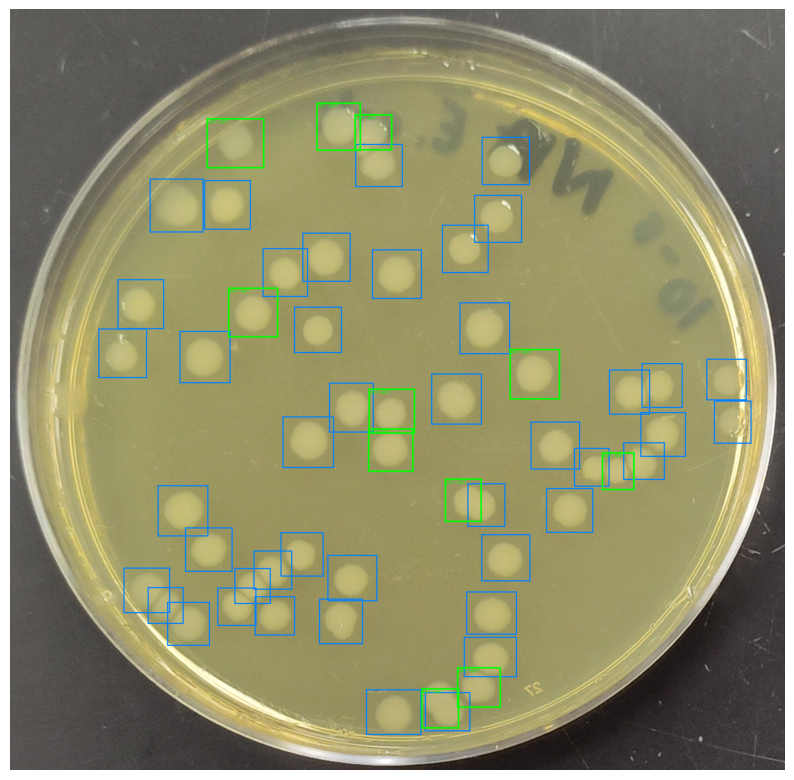

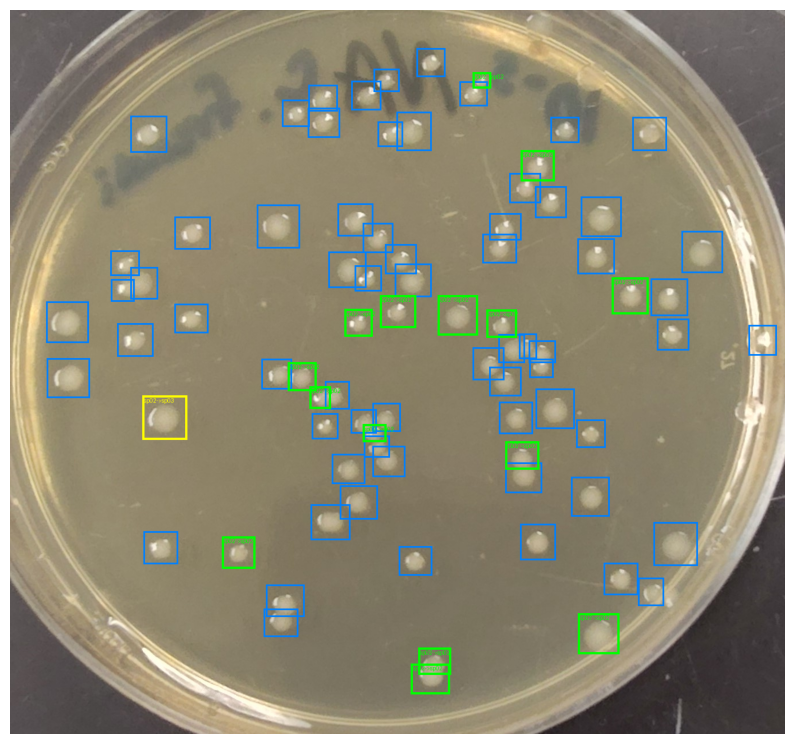

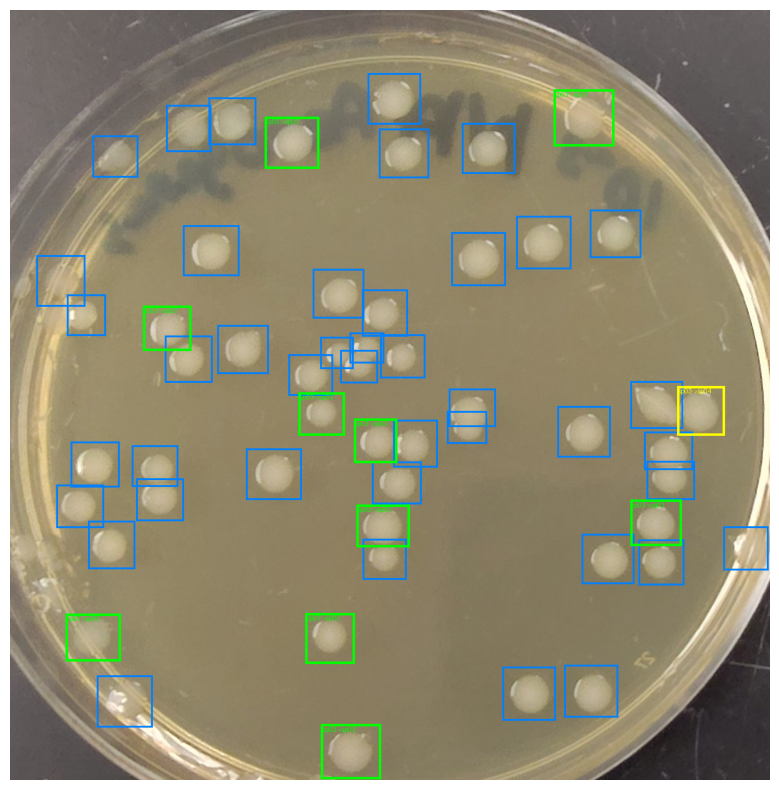

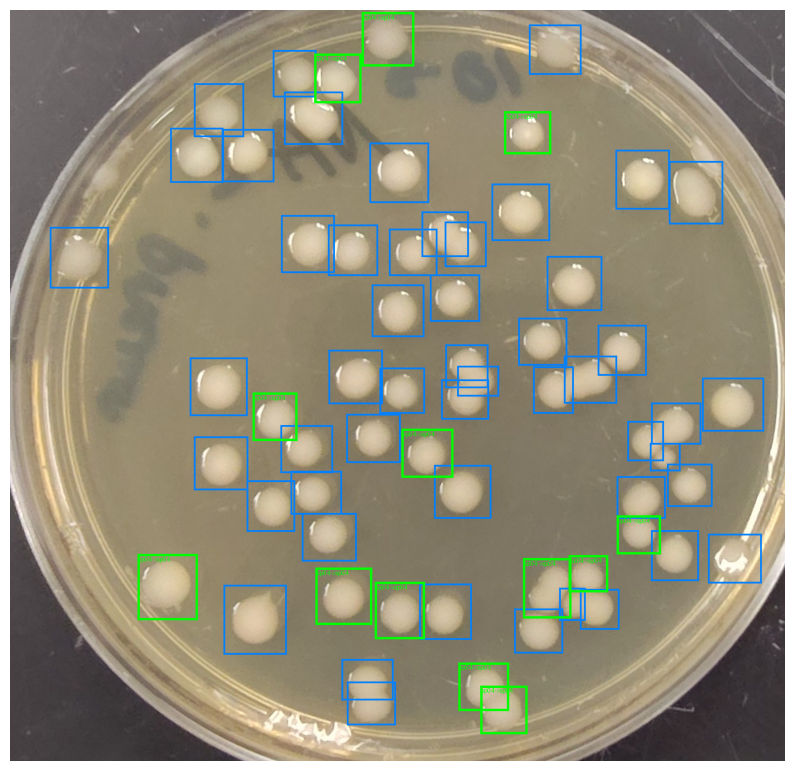


OVERALL TEST SUMMARY (from test_df_gt boxes)
Test boxes total : 51
Test correct (TP): 49
Test wrong (FN)  : 2
Test accuracy     : 0.9607843137066514
PATCH_SIZE        : 100
BOX_EXPAND        : 0.2
PAD_TO_SQUARE     : True


In [ ]:
import os
import numpy as np
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torchvision.models as models
import torch.nn as nn

# ---------------------------
# SETTINGS (must match training)
# ---------------------------
FT_CKPT_PATH = os.path.join(WORKDIR_FINETUNE, "best_finetuned_on_newtest.pt")

PATCH_SIZE     = globals().get("PATCH_SIZE", 100)
BOX_EXPAND     = globals().get("BOX_EXPAND", 0.20)
PAD_TO_SQUARE  = globals().get("PAD_TO_SQUARE", True)

MAX_IMAGES_TO_PLOT = None  # None = all

LINE_WIDTH_TRAIN = 3
LINE_WIDTH_TEST  = 4

# Colors
BLUE   = (0, 128, 255)   # TRAIN boxes
GREEN  = (0, 255, 0)     # TEST correct (TP)
YELLOW = (255, 255, 0)   # TEST wrong (FN)

# ---------------------------
# Checks
# ---------------------------
assert "train_df_gt" in globals(), "train_df_gt not found. Run your train/test split cell first."
assert "test_df_gt" in globals(), "test_df_gt not found. Run your train/test split cell first."
assert "CLASSES_FT" in globals(), "CLASSES_FT not found."
assert "test_tf" in globals(), "test_tf not found."
assert "DEVICE" in globals(), "DEVICE not found."
assert os.path.exists(FT_CKPT_PATH), f"Missing checkpoint: {FT_CKPT_PATH}"
assert "crop_patch" in globals(), (
    "crop_patch() not found. Run the cell where crop_patch is defined "
    "(the same one used inside ColonyPatchDatasetCached)."
)

# ---------------------------
# Load model
# ---------------------------
model_viz = models.resnet18(weights=None)
model_viz.fc = nn.Linear(model_viz.fc.in_features, len(CLASSES_FT))
model_viz.load_state_dict(torch.load(FT_CKPT_PATH, map_location=DEVICE))
model_viz = model_viz.to(DEVICE)
model_viz.eval()

class_to_idx = {c:i for i,c in enumerate(CLASSES_FT)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

# ---------------------------
# Helpers
# ---------------------------
def get_image_path_for_image_name(image_name: str):
    for df in [test_df_gt, train_df_gt]:
        if "image_path" in df.columns:
            row = df[df["image_name"].astype(str) == str(image_name)]
            if len(row) > 0:
                p = row["image_path"].dropna().astype(str).iloc[0]
                if os.path.exists(p):
                    return p
    return os.path.join(IMAGES_DIR_GT, str(image_name))

def make_patch_exactly_like_dataset(img_gray_L, x, y, w, h):
    """
    Match your dataset behavior, BUT also force final resize so stack() works.
    """
    patch_L = crop_patch(
        img_gray_L,
        x, y, w, h,
        pad_to_square=PAD_TO_SQUARE,
        expand_factor=BOX_EXPAND
    )

    # ✅ FORCE same size (this is what your Dataset should ensure)
    patch_L = patch_L.resize((PATCH_SIZE, PATCH_SIZE))

    patch_rgb = Image.merge("RGB", (patch_L, patch_L, patch_L))
    return test_tf(patch_rgb)

# ---------------------------
# Iterate images (union of train/test)
# ---------------------------
train_imgs = set(train_df_gt["image_name"].astype(str).unique().tolist())
test_imgs  = set(test_df_gt["image_name"].astype(str).unique().tolist())
all_images = sorted(list(train_imgs.union(test_imgs)))

print("Unique images (train ∪ test):", len(all_images))

if MAX_IMAGES_TO_PLOT is not None:
    all_images = all_images[:MAX_IMAGES_TO_PLOT]
    print("Limiting to first", len(all_images), "images")

# ---------------------------
# Plot each image:
#   TRAIN boxes = Blue
#   TEST boxes  = Green if correct, Yellow if wrong
# ---------------------------
grand_test_correct = 0
grand_test_wrong = 0
grand_test_total = 0

for idx, image_name in enumerate(all_images, start=1):
    df_tr = train_df_gt[train_df_gt["image_name"].astype(str) == image_name].copy().reset_index(drop=True)
    df_te = test_df_gt[test_df_gt["image_name"].astype(str) == image_name].copy().reset_index(drop=True)

    img_path = get_image_path_for_image_name(image_name)
    if not os.path.exists(img_path):
        print(f"[{idx}/{len(all_images)}] Missing image, skipping:", img_path)
        continue

    img_draw = Image.open(img_path).convert("RGB")
    img_gray = Image.open(img_path).convert("L")

    draw = ImageDraw.Draw(img_draw)

    # TRAIN boxes
    for _, r in df_tr.iterrows():
        x = float(r["bbox_x"]); y = float(r["bbox_y"])
        w = float(r["bbox_width"]); h = float(r["bbox_height"])
        draw.rectangle([x, y, x+w, y+h], outline=BLUE, width=LINE_WIDTH_TRAIN)

    # TEST boxes (predict + correctness)
    xs = []
    meta = []
    for _, r in df_te.iterrows():
        x = float(r["bbox_x"]); y = float(r["bbox_y"])
        w = float(r["bbox_width"]); h = float(r["bbox_height"])
        true_name = str(r["label_name"])

        xs.append(make_patch_exactly_like_dataset(img_gray, x, y, w, h))
        meta.append((x, y, w, h, true_name))

    test_correct = 0
    test_wrong = 0

    if len(xs) > 0:
        X = torch.stack(xs).to(DEVICE)
        with torch.no_grad():
            logits = model_viz(X)
            y_pred = logits.argmax(dim=1).cpu().numpy()

        for (x, y, w, h, true_name), pred_idx in zip(meta, y_pred):
            pred_name = idx_to_class[int(pred_idx)]
            if pred_name == true_name:
                color = GREEN
                test_correct += 1
            else:
                color = YELLOW
                test_wrong += 1

            draw.rectangle([x, y, x+w, y+h], outline=color, width=LINE_WIDTH_TEST)
            draw.text((x+2, y+2), f"{true_name}->{pred_name}", fill=color)

    grand_test_correct += test_correct
    grand_test_wrong += test_wrong
    grand_test_total += (test_correct + test_wrong)

    acc_img = test_correct / (test_correct + test_wrong + 1e-9)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_draw)
    plt.axis("off")
    '''
    plt.title(
        f"{image_name} | TRAIN=Blue({len(df_tr)}) | TEST TP=Green({test_correct}) FN=Yellow({test_wrong}) | TestAcc={acc_img:.3f}"
    )'''
    plt.show()

overall_test_acc = grand_test_correct / (grand_test_total + 1e-9)
print("\n==========================")
print("OVERALL TEST SUMMARY (from test_df_gt boxes)")
print("==========================")
print("Test boxes total :", grand_test_total)
print("Test correct (TP):", grand_test_correct)
print("Test wrong (FN)  :", grand_test_wrong)
print("Test accuracy     :", overall_test_acc)
print("PATCH_SIZE        :", PATCH_SIZE)
print("BOX_EXPAND        :", BOX_EXPAND)
print("PAD_TO_SQUARE     :", PAD_TO_SQUARE)
